In [1]:
# Quick hack to put us in the icenet-pipeline folder, assuming it was created as per 01.cli_demonstration.ipynb
import os
if os.path.exists("02.data_and_forecasts.ipynb"):
    os.chdir("../notebook-pipeline")
print("Running in {}".format(os.getcwd()))

%matplotlib inline

Running in /data/hpcdata/users/jambyr/icenet/notebook-pipeline


# IceNet Data and Forecast Products

## Context

### Purpose
The IceNet library provides the ability to download, process, train and predict from end to end via a set of command-line interfaces.

Using this notebook one can understand the various data sources, intermediaries and products that arise from the [CLI demonstrator notebook](01.cli_demonstration.ipynb) activities.

### Modelling approach
This modelling approach allows users to immediately utilise the library for producing sea ice concentraion forecasts.

### Highlights
The key features of an end to end run are: 
* Setup: _this was concerned with setting up the conda environment, which remains the same_
* [Download](#Download): we explore the source data downloaded under the `/data/` folder, reusable across multiple environments
* [Process](#Process): we explore the preprocessing outputs in the `/processed/` folder, which can be fed to models directly or further processed into IceNet datasets
* [Train](#Train): we explore the outputs from the training process and ensemble runs, stored within `/results/networks/`
* [Predict](#Predict): we explore the output from the prediction process and ensemble runs, stored within `/results/predict/`

_This follows the same structure as the CLI demonstration notebook so that it's easy to follow step-by-step..._

### Contributions
#### Notebook
James Byrne (author)

__Please raise issues [in this repository](https://github.com/antarctica/IceNet-Pipeline) to suggest updates to this notebook!__ 

Contact me at _jambyr \<at\> bas.ac.uk_ for anything else...

#### Modelling codebase
James Byrne (code author), Tom Andersson (science author)

#### Modelling publications
Andersson, T.R., Hosking, J.S., Pérez-Ortiz, M. et al. Seasonal Arctic sea ice forecasting with probabilistic deep learning. Nat Commun 12, 5124 (2021). https://doi.org/10.1038/s41467-021-25257-4

#### Involved organisations
The Alan Turing Institute and British Antarctic Survey

## Setup

For the purposes of python analysis we use and provide the following header libraries which are heavily utilised within the IceNet project and the pipeline.

In [2]:
import glob, json, os, sys
import datetime as dt
import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt
from IPython.display import HTML

## Download

Downloading data using the icenet_data commands produces a dataset specific input data storage directory called `/data` whose source data can be reused across normalisation (`icenet_process*`) and dataset production (`icenet_dataset*`) runs.

In [3]:
os.listdir("data")

['masks', 'era5', 'osisaf']

The structure of these directories (aside from masks) have consistent layouts:

In [4]:
glob.glob("data/**/2020.nc", recursive=True)

['data/era5/south/uas/2020.nc',
 'data/era5/south/vas/2020.nc',
 'data/era5/south/tas/2020.nc',
 'data/era5/south/zg250/2020.nc',
 'data/era5/south/zg500/2020.nc',
 'data/osisaf/south/siconca/2020.nc']

With masks being the only caveat. However, masks can be interacted with purely through the `Masks` class from `icenet2.data.sic.mask`.

In [5]:
glob.glob("data/masks/**/*.*", recursive=True)

['data/masks/south/masks/masks.params',
 'data/masks/south/masks/active_grid_cell_mask_01.npy',
 'data/masks/south/masks/land_mask.npy',
 'data/masks/south/masks/active_grid_cell_mask_02.npy',
 'data/masks/south/masks/active_grid_cell_mask_03.npy',
 'data/masks/south/masks/active_grid_cell_mask_04.npy',
 'data/masks/south/masks/active_grid_cell_mask_05.npy',
 'data/masks/south/masks/active_grid_cell_mask_06.npy',
 'data/masks/south/masks/active_grid_cell_mask_07.npy',
 'data/masks/south/masks/active_grid_cell_mask_08.npy',
 'data/masks/south/masks/active_grid_cell_mask_09.npy',
 'data/masks/south/masks/active_grid_cell_mask_10.npy',
 'data/masks/south/masks/active_grid_cell_mask_11.npy',
 'data/masks/south/masks/active_grid_cell_mask_12.npy',
 'data/masks/south/siconca/2000/01/ice_conc_sh_ease2-250_cdr-v2p0_200001021200.nc',
 'data/masks/south/siconca/2000/02/ice_conc_sh_ease2-250_cdr-v2p0_200002021200.nc',
 'data/masks/south/siconca/2000/03/ice_conc_sh_ease2-250_cdr-v2p0_200003021200.

Note that the `siconca` variable files are source files for generating the masks that are not actually used after initial mask creation.

### Producing data source videos

One of the easiest ways to inspect source data is to use the `icenet_video_data` command, which will output to `/plot/` in the run directory video(s) corresponding to the selected dataset, hemisphere, variable and year, or all of these items if run with: 

In [3]:
!icenet_video_data --years 2020 era5,osisaf

2022-11-24 10:00:44.709112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 10:00:45.633818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/data/hpcdata/users/jambyr/miniconda3/envs/icenet-notebooks/lib/
2022-11-24 10:00:45.633910: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/data/hpcdata/users/jambyr/miniconda3/envs/icenet-noteb

The equivalent can be run for any dataset under `/data/` with this command. The command also exposes numerous options allowing you to refine via the aforementioned items. Consult `-h` for more information.

### Data storage structure

The reason for this structure is that it applies consistency no matter how many different implementations of data downloaders and data processors are in place. The IceNet library (see next notebook) inherits this structure per-implementation from a common set of parents. Aside from making programmitically overriding and implementing new functionality easier, this __consistency means that plotting and analysis of the data stores becomes trivial__, aiding both research and production analysis of data all the way through the pipeline, however it's implemented.

For example, looking at the southern hemisphere sea surface temperature in our example source datastore for the 1st January 2020.

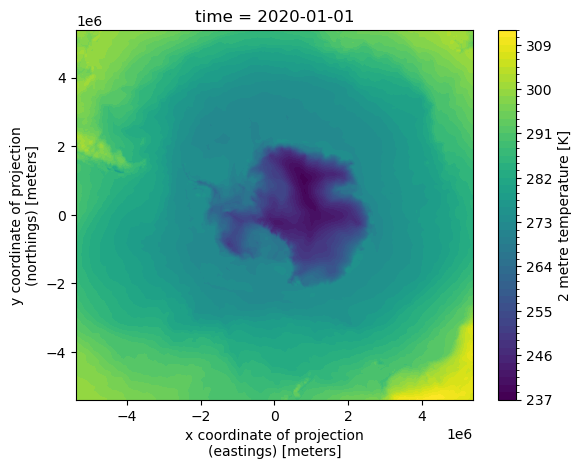

In [6]:
xr.plot.contourf(xr.open_dataset("data/era5/south/tas/2020.nc").isel(time=0).t2m, levels=50)

Against the sea ice for the same day is super intuitive to derive from the filesystem naming, by simply changing the respective dataset and variable.

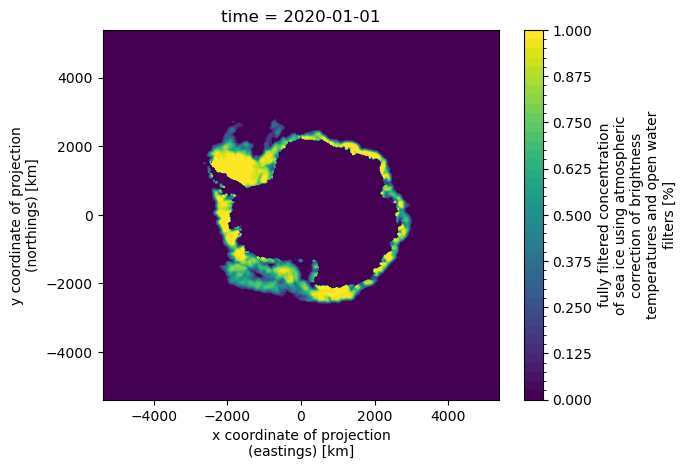

In [7]:
xr.plot.contourf(xr.open_dataset("data/osisaf/south/siconca/2020.nc").isel(time=0).ice_conc, levels=50)

Similarly, switching to the normalised versions (change to `/processed/`) and/or checking other datasets and/or globbing for datasets that can be opened with [`xarray.open_mfdataset`](https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html) is equally trivial thanks to this consistency.

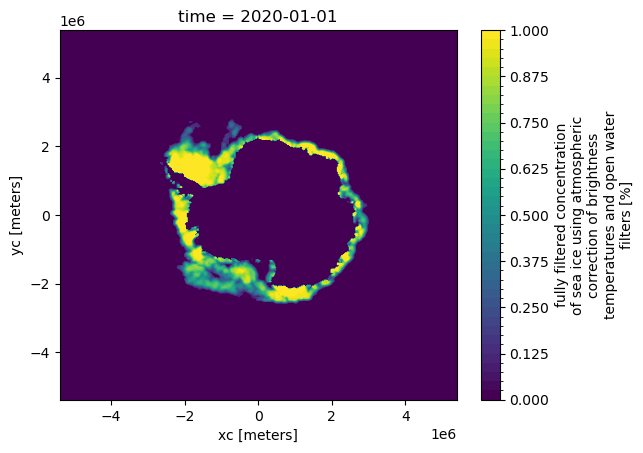

In [9]:
xr.plot.contourf(xr.open_dataarray("processed/notebook_data/osisaf/south/siconca/siconca_abs.nc").isel(time=0), levels=50)

As we'll see later, extending the library to incorporate additional source data simply adds further entries to the `/data` directory, with the implementations ultimately following a consistent approach to storing the data to make more complex analysis trivial.

#### Dask example

For example, needing to inspect the maximum values for sea surface temperature across all 1990's and 2000's data using dask, xarray and glob

```
from dask.distributed import Client
dfs = glob.glob("data/era5/south/tos/19*.nc") + glob.glob("data/era5/south/tos/20*.nc")
client = Client()
ds = xr.open_mfdataset(dfs, combine="nested", concat_dim="time", parallel=True)
a = ds.groupby("time.year").max("time").max(("yc", "xc"))
m = a.compute()
for y in m.year.values:
    print("{} {:.2f}".format(y, float(m.sel(year=y))))
```

## Process

There is a level of consistency (notwithstanding the masks and [this currently open issue for clarity](https://github.com/JimCircadian/icenet2/issues/3)) when looking at the processed files. The key here is that the data is normalised as appropriate via the use of processors defined in `icenet2.data.processors`. 

The associated normalisation/climatological parameters are then stored in an _identified_ processed data folder, with a corresponding `loader.name.json` configuration file which takes the form: 

In [27]:
!cat loader.notebook_data.json

{
    "sources": {
        "era5": {
            "name": "notebook_data",
            "implementation": "IceNetERA5PreProcessor",
            "anom": [
                "tas",
                "zg500",
                "zg250"
            ],
            "abs": [
                "uas",
                "vas"
            ],
            "dates": {
                "train": [
                    "2020_01_01",
                    "2020_01_02",
                    "2020_01_03",
                    "2020_01_04",
                    "2020_01_05",
                    "2020_01_06",
                    "2020_01_07",
                    "2020_01_08",
                    "2020_01_09",
                    "2020_01_10",
                    "2020_01_11",
                    "2020_01_12",
                    "2020_01_13",
                    "2020_01_14",
                    "2020_01_15",
                    "2020_01_16",
                    "2020_01_17",
                    "2020_01_18",
                  

This configuration tracks the various outputs from the normalisation process for each processor used, ensuring that no source data is normalised or modified and can thus be reused across different date ranges easily. At the same time, the caching of this data allows for two additional benefits aside from the obvious separation of preprocessing from data usage. Firstly, the prenormalisation allows uncached datasets to be used directly for predictions and training if desirable and, secondly, it allows multiple datasets to be derived from a single normalisation run which with larger datasets can take a reasonable amount of compute to achieve.

Finally, storing this in a machine and human readable format makes datasets relatively easy to inspect via the loader configuration when you forget what commands you preprocessed with!

__Note that the deeper elements of the configuration file aren't shown for brevity...__

### Producing preprocessed data videos

As with data sources, normalised data is easily visualized at the command line by running the `icenet_video_data` command. _`-p` specifies path to the directory under `/processed/`:

In [2]:
!icenet_video_data -p processed/notebook_data era5,osisaf

2022-11-24 13:43:14.029752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 13:43:15.129125: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/data/hpcdata/users/jambyr/miniconda3/envs/icenet-notebooks/lib/
2022-11-24 13:43:15.129420: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/data/hpcdata/users/jambyr/miniconda3/envs/icenet-noteb

## Train

Training outputs are stored in their respectively named folders using the name provided from the commands `icenet_train` or `run_train_ensemble` respectively. The contents of these folders differ slightly, based simply on the number of runs executed.

In [10]:
os.listdir("results/networks")

['notebook_testrun', 'notebook_ensemble']

The output from the single run provides two appropriately named files, the JSON of the history object from the run and the weights of the network after training.

In [11]:
glob.glob("results/networks/notebook_testrun/**", recursive=True)

['results/networks/notebook_testrun/',
 'results/networks/notebook_testrun/notebook_testrun.network_notebook_data.42.h5',
 'results/networks/notebook_testrun/notebook_testrun.model_notebook_data.42',
 'results/networks/notebook_testrun/notebook_testrun.model_notebook_data.42/variables',
 'results/networks/notebook_testrun/notebook_testrun.model_notebook_data.42/variables/variables.data-00000-of-00001',
 'results/networks/notebook_testrun/notebook_testrun.model_notebook_data.42/variables/variables.index',
 'results/networks/notebook_testrun/notebook_testrun.model_notebook_data.42/assets',
 'results/networks/notebook_testrun/notebook_testrun.model_notebook_data.42/fingerprint.pb',
 'results/networks/notebook_testrun/notebook_testrun.model_notebook_data.42/saved_model.pb',
 'results/networks/notebook_testrun/notebook_testrun.model_notebook_data.42/keras_metadata.pb',
 'results/networks/notebook_testrun/notebook_testrun_42_history.json',
 'results/networks/notebook_testrun/notebook_testrun

Similarly, the ensemble outputs the same files across each individual run, distinguished by the seed.

In [16]:
glob.glob("results/networks/notebook_ensemble/**/*.h5", recursive=True) + glob.glob("results/networks/notebook_ensemble/**/*.json", recursive=True)

['results/networks/notebook_ensemble/notebook_ensemble.network_notebook_data.46.h5',
 'results/networks/notebook_ensemble/notebook_ensemble.network_notebook_data.42.h5',
 'results/networks/notebook_ensemble/notebook_ensemble.network_notebook_data.45.h5',
 'results/networks/notebook_ensemble/notebook_ensemble.network_notebook_data.17.h5',
 'results/networks/notebook_ensemble/notebook_ensemble.network_notebook_data.24.h5',
 'results/networks/notebook_ensemble/notebook_ensemble.network_notebook_data.84.h5',
 'results/networks/notebook_ensemble/notebook_ensemble.network_notebook_data.83.h5',
 'results/networks/notebook_ensemble/notebook_ensemble.network_notebook_data.16.h5',
 'results/networks/notebook_ensemble/notebook_ensemble.network_notebook_data.5.h5',
 'results/networks/notebook_ensemble/notebook_ensemble.network_notebook_data.3.h5',
 'results/networks/notebook_ensemble/notebook_ensemble_42_history.json',
 'results/networks/notebook_ensemble/notebook_ensemble_46_history.json',
 'resu

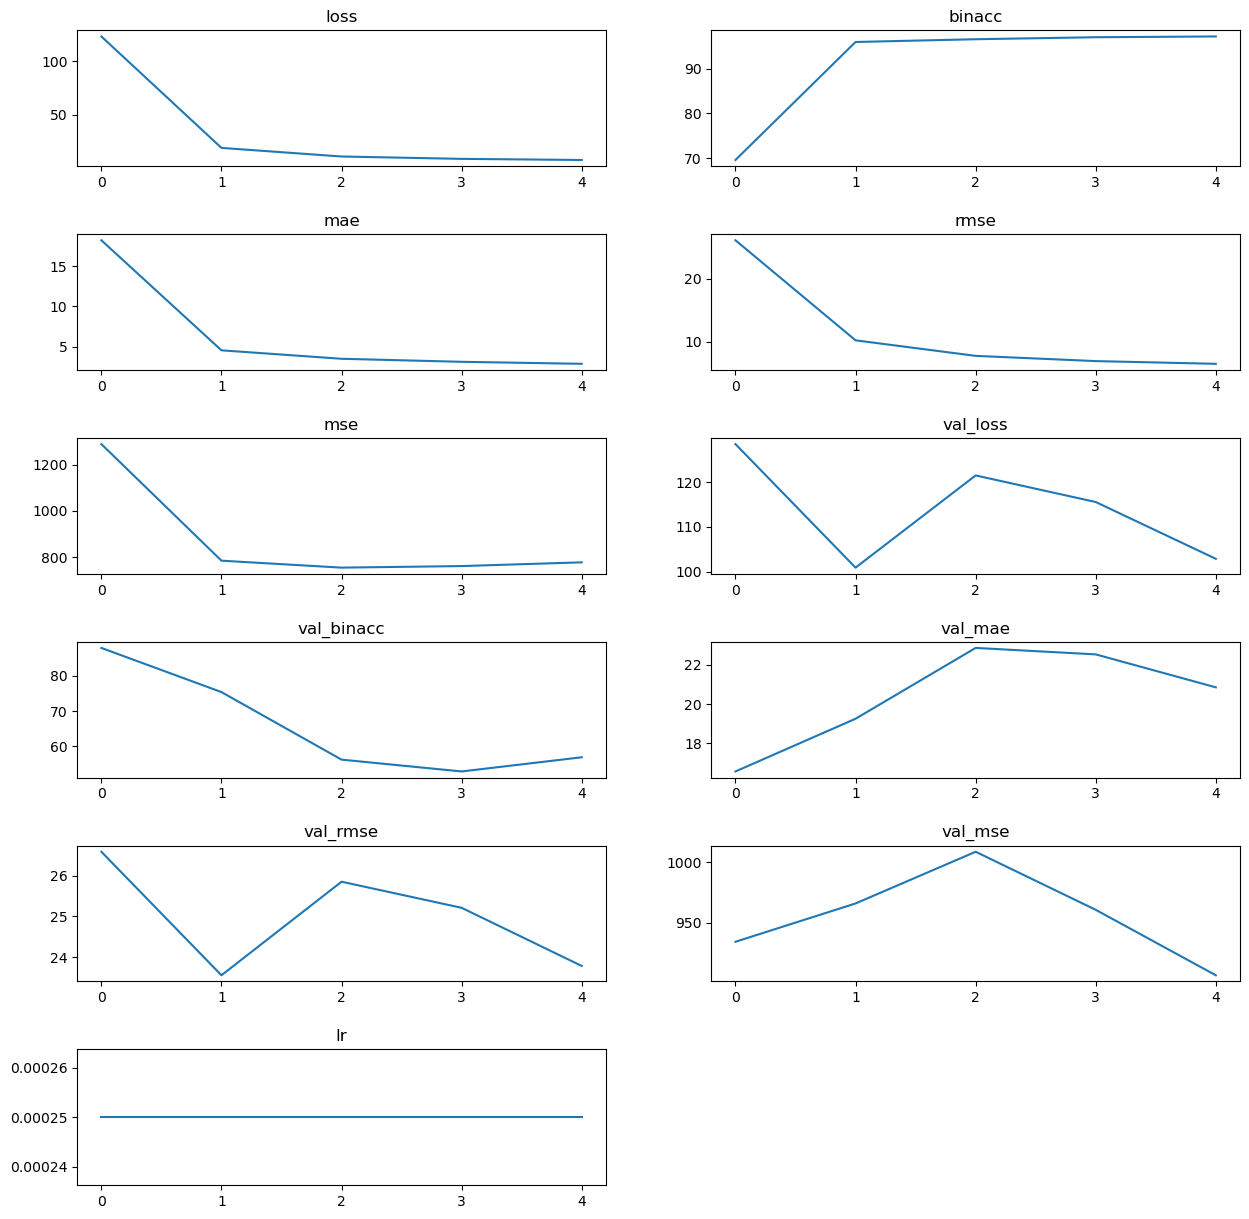

In [21]:
with open("results/networks/notebook_ensemble/notebook_ensemble_45_history.json") as fh:
    history = json.load(fh)

# Quick and dirty visualisation
fig = plt.figure(figsize=(int(len(history.keys())/2) * 3, 15))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

for i, k in enumerate(history.keys()):
    ax = fig.add_subplot(int(len(history.keys())/2) + len(history.keys())%2, 2, i+1)

    ax.plot(history[k].keys(), history[k].values())
    ax.set_title(k)

fig.show()

It's important to note that other outputs result, depending on arguments provided and configuration, from `icenet_train` and `run_icenet_ensemble`. Both tensorboard and WandB outputs can be provided and, in the case of the latter, automatically uploaded when using the CLI tools. The output files are also retained in the run folders, with the latter ensemble members being stored in the `/ensemble/<ensembleName>/<ensembleName>-<runNumber>` directory:

In [22]:
os.listdir("ensemble/notebook_ensemble/notebook_ensemble-0")

['bashpc.sh',
 'icenet_predict.sh.j2',
 'jasmin.sh',
 'local.sh',
 'icenet_train.sh',
 'train.5555551.node022.42.out',
 'train.5555551.node022.42.err',
 'data',
 'ENVS',
 'ENVS.example',
 'ENVS.jambyr.bas',
 'loader.notebook_data.json',
 'dataset_config.notebook_data.json',
 'network_datasets',
 'processed',
 'results',
 'wandb',
 'logs',
 'artifacts']

Depending on the mechanism (in this case SLURM on our HPC) used to run the ensemble, the log files provide the full output from the run:

In [23]:
!cat ensemble/notebook_ensemble/notebook_ensemble-0/train.5555551.node022.42.out

START 2022-12-05 17:49:05
Loading WANDB configuration specifically for BAS
Running icenet_train -v notebook_data notebook_ensemble 42 --lr 0.00025 --shuffle-train --early-stopping 30 -b 4 -e 5 -m -qs 4 -w 4 -s default  -n 0.6
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 432, 432, 9  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 432, 432, 38  3116        ['input_1[0][0]']                
                                )                                                                 
                                                                  

Of course in the case of individual runs using `icenet_train` this output will have been presented to stdout/stderr (the screen) whilst running...

## Predict

The training runs provide insight into the training of the network (using the CLI in a very simple fashion) but the predictions produce actual forecast output to be studied or utilised. This can be evaluated as befits the user in comparison to the original SIC data or any other source to validate the forecasts. **Obviously with our notebook network these won't be accurate** but in real use you'd be expecting to produce comparable forecasts with the physics based data used to train the network.

All outputs for prediction runs using either `icenet_predict` or `run_predict_ensemble` are stored in `results/predict`. For our notebook test and ensemble runs we can see the folder structure is similar to the training outputs, with folders named using the identifier:

In [24]:
glob.glob("results/predict/**")

['results/predict/example_south_forecast',
 'results/predict/example_south_ensemble_forecast',
 'results/predict/example_south_ensemble_forecast.nc',
 'results/predict/example_south_forecast.nc']

In [25]:
os.listdir("results/predict/example_south_ensemble_forecast")

['notebook_ensemble.42',
 'notebook_ensemble.45',
 'notebook_ensemble.5',
 'notebook_ensemble.17',
 'notebook_ensemble.46',
 'notebook_ensemble.24',
 'notebook_ensemble.84',
 'notebook_ensemble.83',
 'notebook_ensemble.16',
 'notebook_ensemble.3']

In [26]:
os.listdir("results/predict/example_south_ensemble_forecast/notebook_ensemble.45")

['2020_04_01.npy', 'loader', '2020_04_02.npy']

The prediction per-network folder contains output from the network for the inputs provided, with the dates being the forecast start date. These files correspond to the *original dates we provided in the first notebook*. 

In [28]:
!cat testdates.csv

2020-04-01
2020-04-02


In the `loader` are also contained `outputs` and `weights`. The former "outputs" are the generated outputs for the network that would've been used for training. Remember, that to produce a forecast we use an input linear trend SIC channel set, alongside the atmospheric and other data channels. The weights is the collection of sample weights associated to the input set. These are really provided for debugging purposes, but may also be of some analytical interest in some cases. 

With the run of `icenet_output` as shown in the first notebook, these numpy-saved outputs are converted to a CF-compliant NetCDF that can be forwarded on or usefully analysed. 

### Plotting a forecast

The following snippet uses one of these NetCDF's for plotting a forecast:

In [30]:
from icenet.plotting.video import xarray_to_video as xvid
from icenet.data.sic.mask import Masks

ds = xr.open_dataset("results/predict/example_south_ensemble_forecast.nc")
land_mask = Masks(south=True, north=False).get_land_mask()
ds.info()

2022-12-05 19:53:22.128250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 19:53:23.134515: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-05 19:53:23.134600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-05 19:53:23.134608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

xarray.Dataset {
dimensions:
	time = 2 ;
	yc = 432 ;
	xc = 432 ;
	leadtime = 7 ;

variables:
	int32 Lambert_Azimuthal_Grid() ;
		Lambert_Azimuthal_Grid:grid_mapping_name = lambert_azimuthal_equal_area ;
		Lambert_Azimuthal_Grid:longitude_of_projection_origin = 0.0 ;
		Lambert_Azimuthal_Grid:latitude_of_projection_origin = -90.0 ;
		Lambert_Azimuthal_Grid:false_easting = 0.0 ;
		Lambert_Azimuthal_Grid:false_northing = 0.0 ;
		Lambert_Azimuthal_Grid:semi_major_axis = 6378137.0 ;
		Lambert_Azimuthal_Grid:inverse_flattening = 298.257223563 ;
		Lambert_Azimuthal_Grid:proj4_string = +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=-90.0 ;
	float32 sic_mean(time, yc, xc, leadtime) ;
		sic_mean:long_name = mean sea ice area fraction across ensemble runs of icenet model ;
		sic_mean:standard_name = sea_ice_area_fraction ;
		sic_mean:short_name = sic ;
		sic_mean:valid_min = 0 ;
		sic_mean:valid_max = 1 ;
		sic_mean:ancillary_variables = sic_stddev ;
		sic_mean:grid_mapping = Lambert_Azimuth

In [31]:
forecast_date = ds.time.values[0]
print(forecast_date)

2020-04-01T00:00:00.000000000


In [33]:
fc = ds.sic_mean.isel(time=0).drop_vars("time").rename(dict(leadtime="time"))
fc['time'] = [pd.to_datetime(forecast_date) \
              + dt.timedelta(days=int(e)) for e in fc.time.values]

anim = xvid(fc, 15, figsize=4, mask=land_mask)
HTML(anim.to_jshtml())

Obviously, with the size and training of the notebook dataset this is not a particularly useful forecast but the ease of generating a visual is hopefully apparent. Also, this segways nicely into the next notebook as we've started to introduce leverages methods and classes directly from the icenet2 API itself. 

In [ ]:
# TODO: Fix above plotting of forecast_date image in library
# TODO: apply mask to results correctly
# TODO: visually exemplify comparison with source SIC dataset

## Summary

In this notebook we've explored the data assets that are stored based on the end to end run of the pipeline, hopefully enough to make the user aware of the structuring of the run directory when using either single-run or ensemble-based mechanisms of execution. Using illustrative but minimal data, we've highlighted the potential use of these assets to generate visual products and give insight into the processing that takes place. 

Those interested in running forecasts with a properly scaled training and prediction set of data should now be able to consider doing so using the CLI commands. However, the CLI commands **only expose an illustrative set of commands at present**, whereas leveraging the API directly affords far more flexibility. This is explored in the remaining notebooks: 

* [Library usage](03.library_usage.ipynb): understand how to programmatically perform an end to end run.
* [Library extension](04.library_extension.ipynb): understand why and how to extend the IceNet library.

## Version
- IceNet Codebase: v0.2.0.dev10

